# Source contributions

In [1]:
import pickle
import numpy as np
import xarray as xr
import pandas as pd
from calendar import monthrange
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import datetime as dt
import os
from itertools import compress
from mpl_toolkits.basemap import Basemap

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

# model result set:
folder_base = '/data/brogalla/run_storage/Pb-reference-202303/'

colors  = ['#bea385','#bea385','#bacbda','#bacbda','#a0a3a3','#67b1b5','#337d80', '#7b5a48']
land_color         = '#a9a7a2'
land_outline_color = '#373736'

In [3]:
bdy_NCB = (1598,2177,778,798) # Northern Canada Basin 
bdy_WCB = (2168,2178,390,797) # Western Canada Basin 
bdy_LS  = (1140,1150,446,672) # Baffin Bay
bdy_HB  = (1190,1472,293,303) # Hudson Bay

In [4]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, \
         2017, 2018, 2019]

#### Load files:

In [5]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
ANHA12_lon   = mfile['nav_lon'].values
ANHA12_lat   = mfile['nav_lat'].values
tmask        = mfile['tmask'].values
tmask_sub    = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask_sub[:,:,:] > 0.1), tmask_sub[:,:,:]) 

mesh      = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
e3t       = mesh['e3t_0'].values[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), e3t)
nav_lev   = mesh['nav_lev'].values

#### Functions:

In [7]:
# estimate at a transect at the edge of the boundary
# Need: dPb concentration and flow volume 
# mol/L * m3 / s * 1e3 L/m3 = mol/s * 3600*24*days_in_month = mol / month (sum over year) --> mol/yr *1e-6 = Mmol/yr

def calc_transports(ts):
    # sum over transect
    fday   = np.nansum(ts*1e3*(5*3600*24), axis=(1,2)) # mol m3/L s --> mol /s by multiplying by 1e3 --> mol/5 days
    annual = np.nansum(fday, axis=(0))*1e-6  # mol/yr --> Mmol/yr
    return fday, annual

## Calculate inflow/outflow through the boundaries
Boundaries:
- western Canada Basin
- northern Canada Basin
- Labrador Sea
- Hudson Bay

In [9]:
interannual_nCB = np.empty(len(years))
interannual_wCB = np.empty(len(years))
interannual_HB  = np.empty(len(years))
interannual_LS  = np.empty(len(years))

for y, year in enumerate(years):
    base = '/ocean/brogalla/GEOTRACES/time-series/Pb-model/Pb-reference-202303/'
    ts_nCB, ts_wCB, ts_HB, ts_LS = pickle.load(open(f'{base}time-series-{year}.pickle','rb'))  

    __, interannual_nCB[y] = calc_transports(ts_nCB) 
    __, interannual_wCB[y] = calc_transports(ts_wCB)
    __, interannual_HB[y]  = calc_transports(ts_HB) 
    __, interannual_LS[y]  = calc_transports(ts_LS)

In [10]:
print('Addition of Pb from boundaries (Mmol/yr):')
print(f'Northern Canada Basin --- {-interannual_nCB.mean():.3f}')
print(f'Western Canada Basin  --- {-interannual_wCB.mean():.3f}')
print(f'Hudson Bay            --- {interannual_HB.mean():.3f}')
print(f'Labrador Sea          --- {interannual_LS.mean():.3f}')

Addition of Pb from boundaries (Mmol/yr):
Northern Canada Basin --- 0.213
Western Canada Basin  --- 0.174
Hudson Bay            --- -0.006
Labrador Sea          --- 1.276


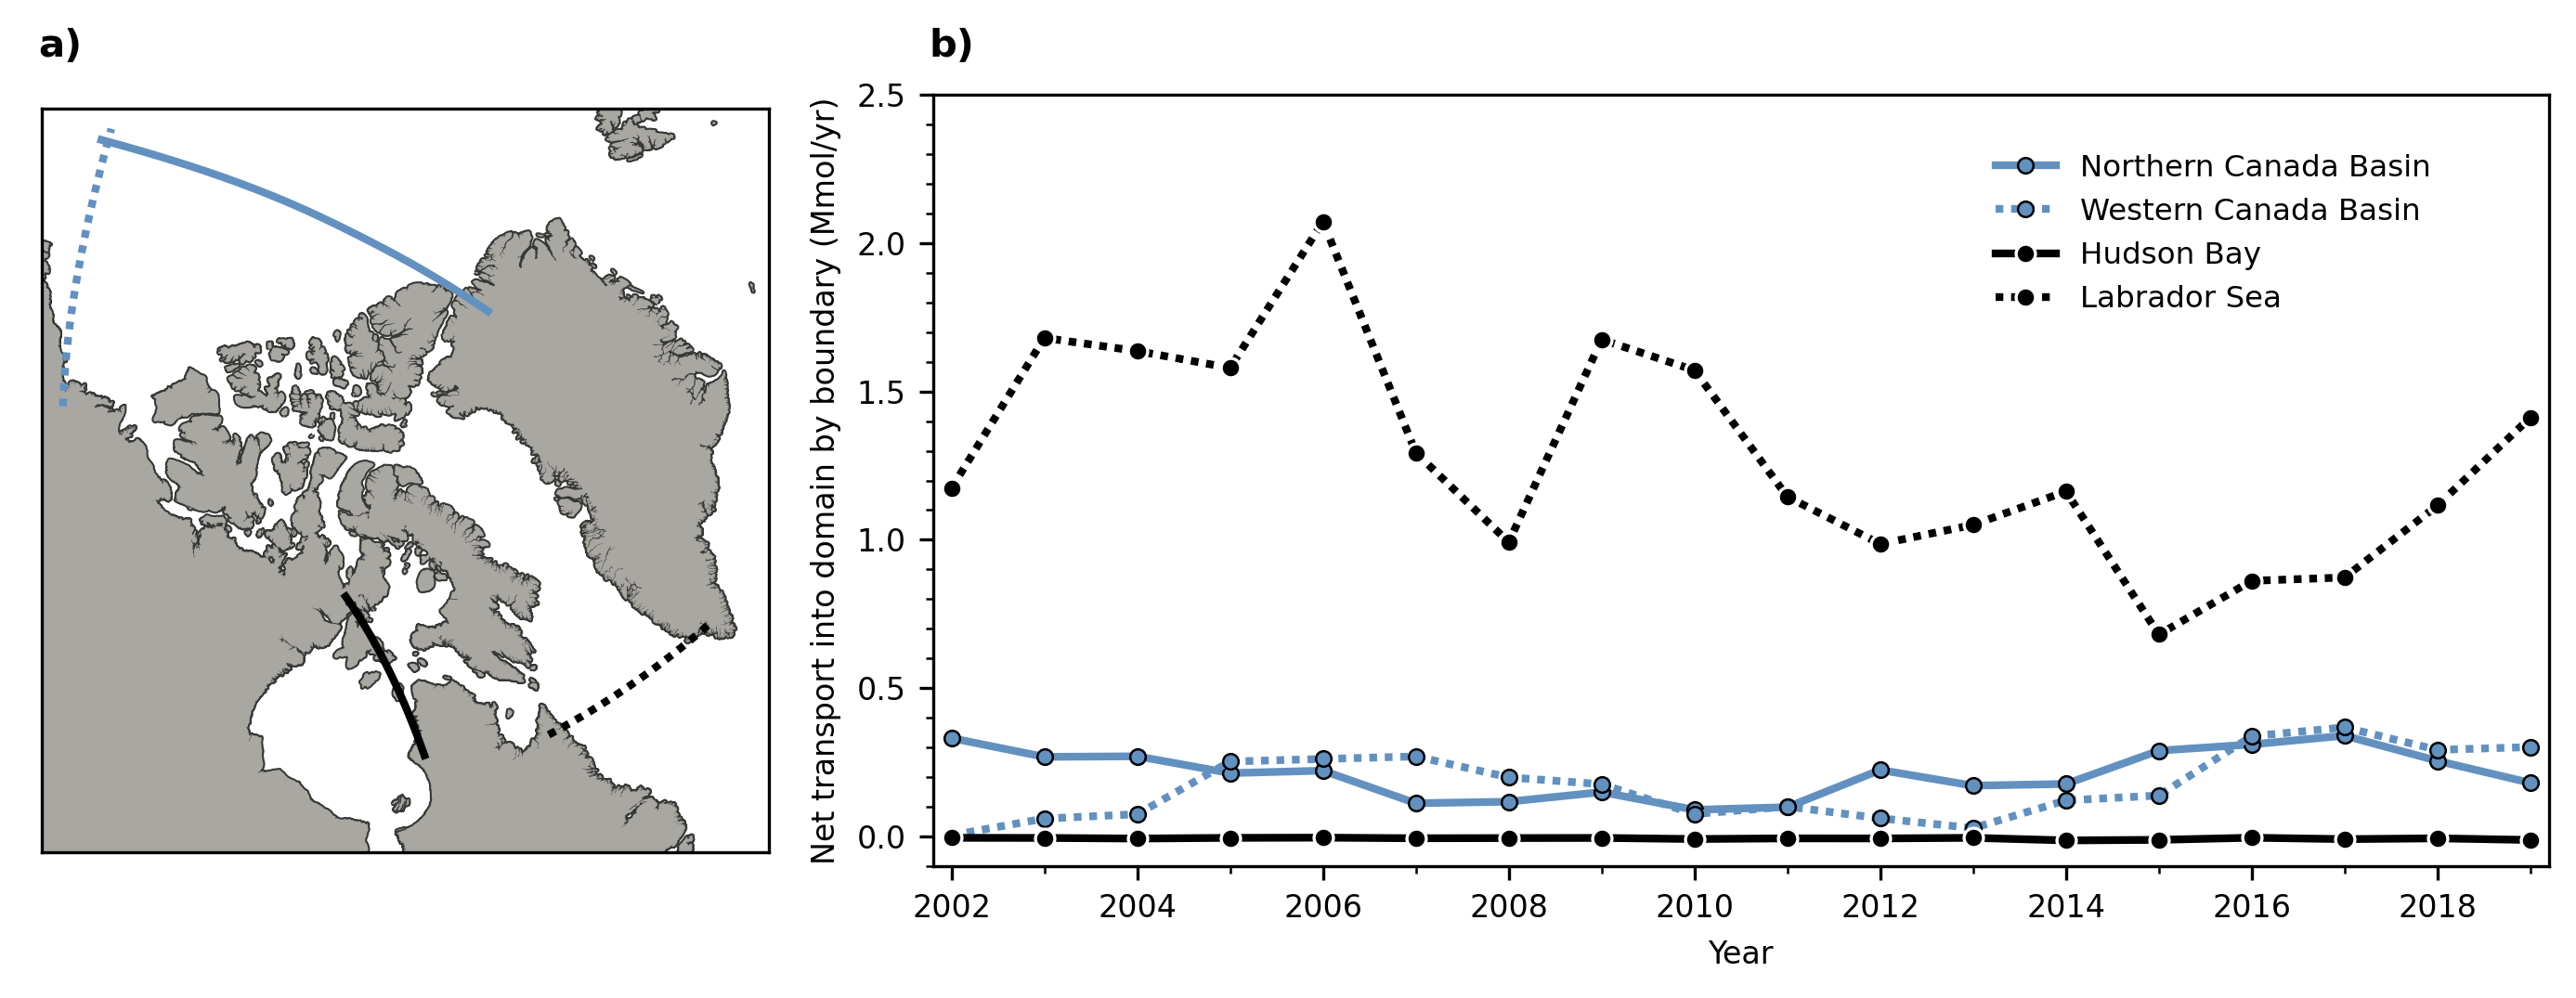

In [31]:
fig, ax = plt.subplots(1,2, figsize=(4.7*2,3.5), dpi=300, gridspec_kw={'width_ratios': [0.9, 2]})

# left: Map
proj1=Basemap(projection='eqdc',lat_0 = 73, lon_0 = -79, resolution='i', width=4.2e6, height=4.3e6, ax=ax[0])
proj1.drawcoastlines(color=land_outline_color, linewidth=1.0);
proj1.fillcontinents(color=land_color, lake_color=land_color, zorder=2);
x_sub, y_sub  = proj1(ANHA12_lon, ANHA12_lat) 
color_LS = 'k'; color_wCB = '#6291c0';
color_HB = 'k'; color_nCB = '#6291c0';
proj1.plot(x_sub[1150,446:672] , y_sub[1150,446:672] , linestyle=(0, (1, 1)), c=color_LS , lw=2);
proj1.plot(x_sub[2168,390:797] , y_sub[2168,390:797] , linestyle=(0, (1, 1)), c=color_wCB, lw=2); 
proj1.plot(x_sub[1598:2177,778], y_sub[1598:2177,778], linestyle='solid', c=color_nCB, lw=2); 
proj1.plot(x_sub[1190:1472,303], y_sub[1190:1472,303], linestyle='solid', c=color_HB , lw=2); 

# right:
ax[1].tick_params(axis='both', labelsize=8)
ax[1].set_ylim(-0.1,2.5)
ax[1].set_xlim(2001.8,2019.2)
ax[1].set_xlabel('Year', fontsize=8)
ax[1].xaxis.set_major_locator(MultipleLocator(2))
ax[1].xaxis.set_minor_locator(MultipleLocator(1))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[1].set_ylabel('Net transport into domain by boundary (Mmol/yr)', fontsize=8)
ax[1].plot(years, -interannual_nCB, linestyle='solid'    , linewidth=2, marker='.',
             markersize=8, markeredgecolor='k', markeredgewidth=0.6, c=color_nCB, label='Northern Canada Basin')
ax[1].plot(years, -interannual_wCB, linestyle=(0, (1, 1)), linewidth=2, marker='.', 
             markersize=8, markeredgecolor='k', markeredgewidth=0.6, c=color_wCB, label='Western Canada Basin')
ax[1].plot(years, interannual_HB  , linestyle='solid'    , linewidth=2, marker='.',
             markersize=10, markeredgecolor='w', markeredgewidth=0.8, c=color_HB, label='Hudson Bay')
ax[1].plot(years, interannual_LS  , linestyle=(0, (1, 1)), linewidth=2, marker='.',
             markersize=10, markeredgecolor='w', markeredgewidth=0.8, c=color_LS, label='Labrador Sea')
ax[1].legend(loc=(0.65, 0.7), fontsize=7.8, frameon=False)
    
fig.text(0.02, 0.98, 'a)', fontsize=10, weight='bold');
fig.text(0.36, 0.98, 'b)', fontsize=10, weight='bold');
    
plt.tight_layout()
fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/R5-boundary-transport.jpg', dpi=300, bbox_inches='tight')

Visualize transport at the boundaries:

In [39]:
from math import sin, cos, sqrt, atan2, radians
import netCDF4 as nc
import cmocean
import matplotlib

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

In [123]:
# BC     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb_OBC_y2002m01.nc','r')
BC     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb-tuning-202303/Pb_OBC_y2015m09.nc','r')
# Labrador Sea
dPb_S_lons = mesh_lon[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]] 
dPb_S_lats = mesh_lat[bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]
dPb_S_mdepths = bathy_masked[:,bdy_LS[0]:bdy_LS[1],bdy_LS[2]:bdy_LS[3]]

# Northern Canada Basin
dPb_E_lons = mesh_lon[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 
dPb_E_lats = mesh_lat[bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 
dPb_E_mdepths = bathy_masked[:,bdy_NCB[0]:bdy_NCB[1],bdy_NCB[2]:bdy_NCB[3]] 

# Western Canada Basin
dPb_N_lons = mesh_lon[bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]] 
dPb_N_lats = mesh_lat[bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]
dPb_N_mdepths = bathy_masked[:,bdy_WCB[0]:bdy_WCB[1],bdy_WCB[2]:bdy_WCB[3]]

# Hudson Bay
dPb_W_lons = mesh_lon[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
dPb_W_lats = mesh_lat[bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 
dPb_W_mdepths = bathy_masked[:,bdy_HB[0]:bdy_HB[1],bdy_HB[2]:bdy_HB[3]] 

BC.close()

In [124]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [125]:
# Look at only one slice of the rimwidth thickness boundary:
S_distance  = calc_distance(dPb_S_lats[-1,:]   , dPb_S_lons[-1,:])    # Labrador Sea
N_distance  = calc_distance(dPb_N_lats[-1,:]   , dPb_N_lons[-1,:])    # western CB
E_distance  = calc_distance(dPb_E_lats[:,-1], dPb_E_lons[:,-1]) # northern CB
W_distance  = calc_distance(dPb_W_lats[:,-1], dPb_W_lons[:,-1]) # Hudson Bay

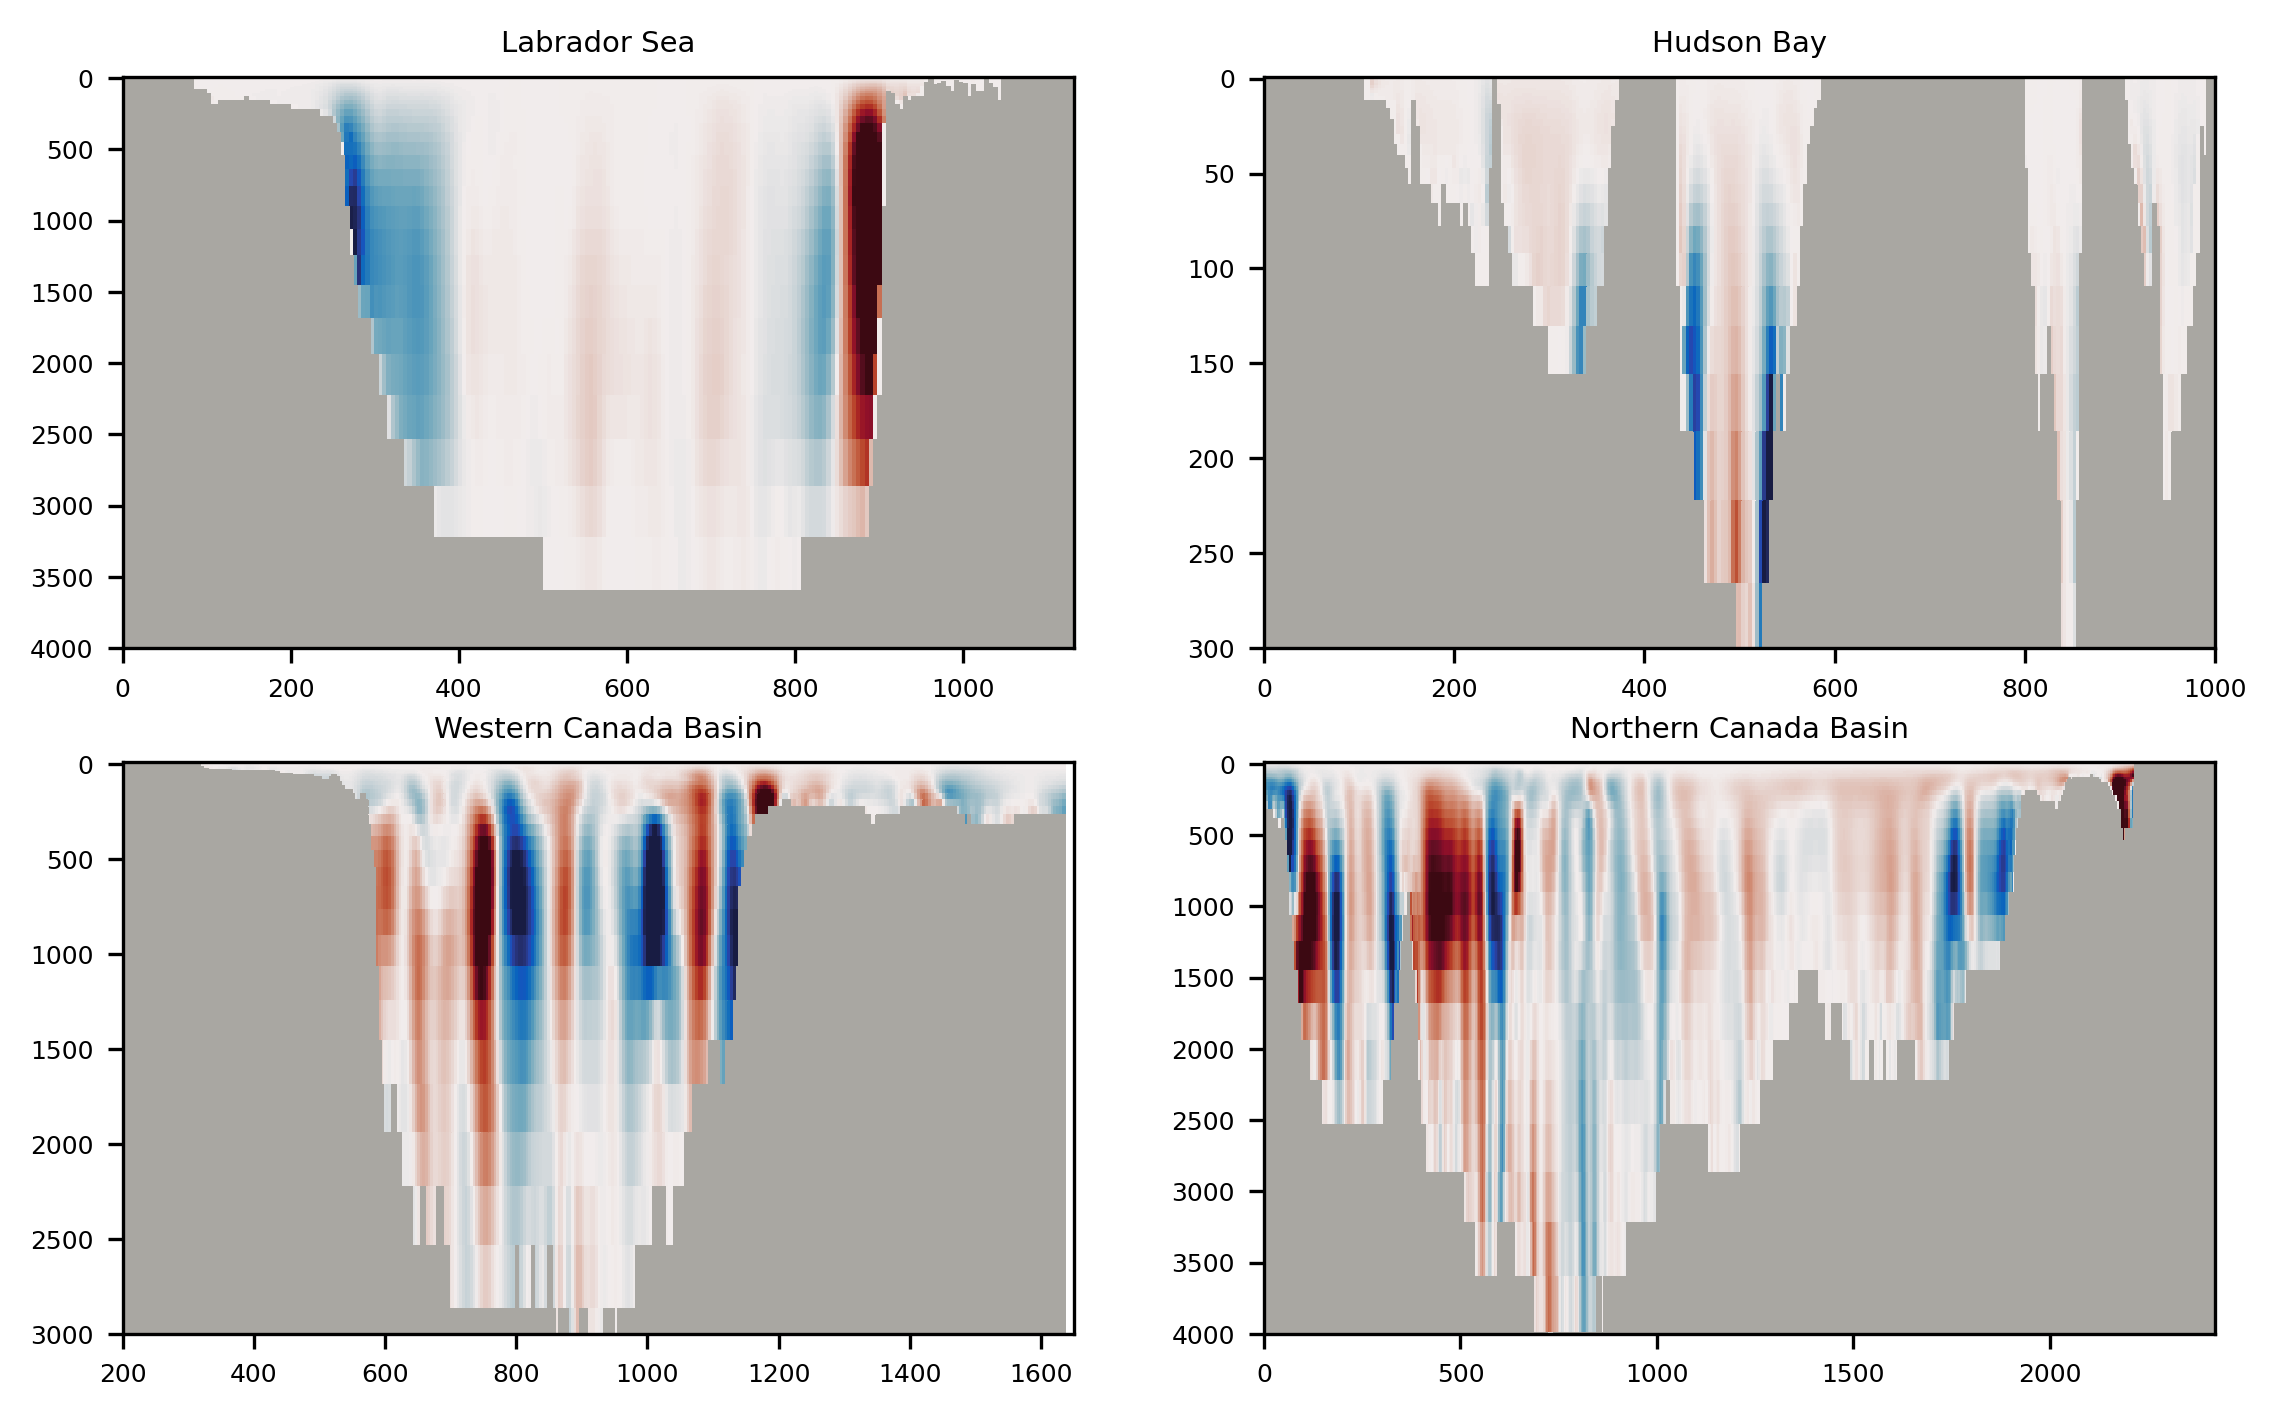

In [127]:
fig, ax = plt.subplots(2,2, figsize=(4.5*2, 3.7*1.5), dpi=300)

ax[0,0].set_title('Labrador Sea', fontsize=7)
ax[0,1].set_title('Hudson Bay', fontsize=7)
ax[1,0].set_title('Western Canada Basin', fontsize=7)
ax[1,1].set_title('Northern Canada Basin', fontsize=7)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.tick_params(axis='both', which='major', labelsize=6)
    
ax[0,0].set_ylim(4000,-10)
ax[0,1].set_ylim(300,-1)
ax[1,0].set_ylim(3000,-10)
ax[1,1].set_ylim(4000,-10)
ax[0,1].set_xlim(0,1000)
ax[1,0].set_xlim(200,1650)

# Labrador Sea:
LS_plot = np.nansum(ts_LS[:,:,:]*1e3*(5*3600*24), axis=(0))*1e-6 # Mmol/yr
xx, zz  = np.meshgrid(S_distance, depths)
CB1 = ax[0,0].pcolormesh(xx, zz, LS_plot, vmin=-0.1, vmax=0.1, cmap=cmocean.cm.balance)
ax[0,0].pcolormesh(xx, zz, dPb_S_mdepths[:,9,0:-1], cmap=matplotlib.colors.ListedColormap([land_color]))

# Hudson Bay: 
HB_plot = np.nansum(ts_HB[:,:,:]*1e3*(5*3600*24), axis=(0))*1e-6 # Mmol/yr
xx, zz = np.meshgrid(W_distance, depths)
CB2 = ax[0,1].pcolormesh(xx, zz, HB_plot, vmin=-1e-3, vmax=1e-3, cmap=cmocean.cm.balance)
ax[0,1].pcolormesh(xx, zz, dPb_W_mdepths[:,0:-1,9], cmap=matplotlib.colors.ListedColormap([land_color]))

# Western Canada Basin:
wCB_plot = np.nansum(ts_wCB[:,:,:]*1e3*(5*3600*24), axis=(0))*1e-6 # Mmol/yr
xx, zz = np.meshgrid(N_distance, depths)
CB3 = ax[1,0].pcolormesh(xx, zz, -wCB_plot, vmin=-1e-3, vmax=1e-3, cmap=cmocean.cm.balance)
ax[1,0].pcolormesh(xx, zz, dPb_N_mdepths[:,9,0:-1], cmap=matplotlib.colors.ListedColormap([land_color]))

# Northern Canada Basin:
nCB_plot = np.nansum(ts_nCB[:,:,:]*1e3*(5*3600*24), axis=(0))*1e-6 # Mmol/yr
xx, zz = np.meshgrid(E_distance[::-1], depths)
CB4 = ax[1,1].pcolormesh(xx, zz, -nCB_plot, vmin=-1e-3, vmax=1e-3, cmap=cmocean.cm.balance)
ax[1,1].pcolormesh(xx, zz, dPb_E_mdepths[:,0:-1,0], cmap=matplotlib.colors.ListedColormap([land_color]))